In [1]:
import pathlib
import os
from glob import glob

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 
import cloudpickle

import SessionTools.two_photon as st2p

import sklearn
from sklearn.linear_model import LinearRegression as LinReg


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['pdf.use14corefonts']=True

%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [5]:
data_dict = {'date': "04_05_2023",
             'fly': "R60D05_GCaMP8s_tdc2lexa_CsChrimsontdT_fly2",
             'sessions': ( 'open_loop_drug-002',
                          'drug_open_loop_0deg-004',
                          'drug_open_loop_180deg-006',
                         ),
             'res': []
}


In [6]:
def make_h5(h5name, metadata):
    if not os.path.exists(h5name):
        tiff_data = st2p.preprocessing.tiff_tools.read(basename_input, 
                                                metadata['size'],metadata['layout'])
        st2p.preprocessing.tiff_tools.convert_to_hdf5(tiff_data,h5name, overwrite=True)
        
def calc_pva(dff):
    x_f,y_f = st2p.utilities.pol2cart(dff,np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])
    rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
    return rho, phi

def calc_offset(heading, pva_angle):
    _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),pva_angle-heading))
    return offset

def calc_heading_vel(heading):
    h_x, h_y = st2p.utilities.pol2cart(np.ones(heading.shape), heading)
    _, dh = st2p.utilities.cart2pol(np.diff(h_x,prepend=0), np.diff(h_y,prepend=0))
    return dh
    

def get_processed_data(date, fly, session, func_ch = 1, align_ch = 1):
    basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/')
    basename_input = pathlib.Path(basedir.joinpath(session))
    metadata = st2p.preprocessing.bruker_metadata.read(basename_input)

    # raw data
    h5name = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/data.h5'
    make_h5(h5name, metadata)
    f = h5py.File(h5name)
    data = f['/data'][:]
    
    # motion corrected
    ref_img = st2p.preprocessing.motion_correction.make_ref_img(data,0)
    data_corr, shifts, error, diffphase = st2p.preprocessing.motion_correction.align_data_chunk(data, ref_img[align_ch,:,:,:], in_place=False)
    
    
    # ROI data
    napari_outputs_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/napari.pkl'
    with open(napari_outputs_file, 'rb') as file:
        np_layers = cloudpickle.load(file)
    masks = np_layers['rois']
    
    # voltage recording data
    csv_files = glob(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/*.csv')
    vr_file = pathlib.Path(csv_files[0])
    df = dd.read_csv(vr_file).compute()
    
    # align voltage recording and imaging data
    frame_times = np.array(metadata['frame_times']).mean(axis=-1)*1000
    df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)
    
    # extract fluorescence
    F, notF = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks, 16, max_proj=False) #+ 1E-3
    lr = LinReg().fit(notF[1,np.newaxis, :].T, F[1,:,:].T)
    F[1,:,:] = F[1,:,:]-1.*lr.predict(notF[1,np.newaxis,:].T).T  + lr.intercept_[:,np.newaxis]
    
    notF = sp.ndimage.gaussian_filter1d(notF,3,axis=-1) # smooth in time
    F = sp.ndimage.gaussian_filter1d(F,2,axis=-1) # smooth in time
    F = sp.ndimage.gaussian_filter1d(F,.5,axis=1, mode='wrap') # smooth in space
    # dff = sp.stats.zscore(F[func_ch,:,:]-notF[func_ch,np.newaxis,:].mean(axis=0,keepdims=True),axis=-1) # z scored fluorescence with background subtraction
    dff = sp.stats.zscore(F[1,:,:],axis=-1)
    
    
    # put heading back in correct range
    _, heading = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones((df_aligned.shape[0],)), 
                                                           np.pi-1*df_aligned[' Heading'].to_numpy().ravel()))
    pva_amp, pva_angle = calc_pva(dff)
    offset = calc_offset(heading, pva_angle)
    heading_vel  = calc_heading_vel(heading)
    
    return {'voltage_recording': df_aligned,
            'dff': dff,
            'heading': heading,
            'pva': {'amp': pva_amp, 'angle': pva_angle},
            'bump_offset': offset,
            'heading_vel': heading_vel}



In [7]:
for sess in data_dict['sessions']:
    print(sess)
    data_dict['res'].append(get_processed_data(data_dict['date'], data_dict['fly'], sess, func_ch=1))

open_loop_drug-002


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
drug_open_loop_0deg-004
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
drug_open_loop_180deg-006
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [8]:
fname = f"/media/mplitt/SSD_storage/2P_scratch/{data_dict['date']}/{data_dict['fly']}/combined_results.pkl"
with open(fname, 'wb') as file:
    cloudpickle.dump(data_dict,file)

In [5]:
fname = f"/media/mplitt/SSD_storage/2P_scratch/{data_dict['date']}/{data_dict['fly']}/combined_results.pkl"
with open(fname, 'rb') as file:
    data_dict = cloudpickle.load(file)

In [9]:
dff = [res['dff'] for res in data_dict['res']]
pva_angle = [res['pva']['angle'] for res in data_dict['res']]
heading = [res['heading'] for res in data_dict['res']]
heading_vel = [res['heading_vel'] for res in data_dict['res']]

offset = [res['bump_offset'] for res in data_dict['res']]


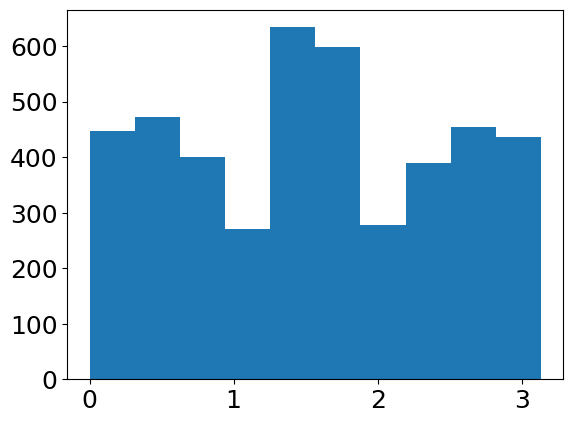

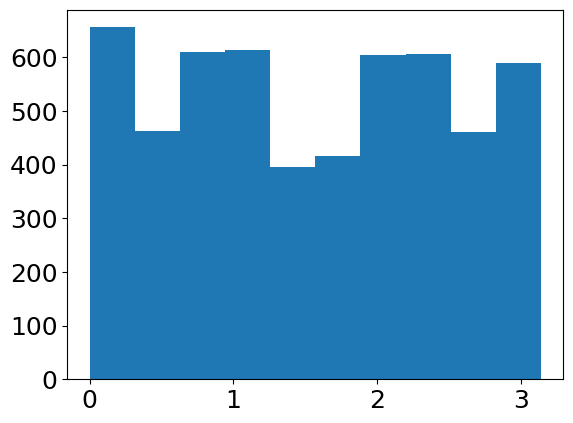

In [13]:
for _hv in heading_vel:
    fig,ax = plt.subplots()
    ax.hist(np.abs(_hv))

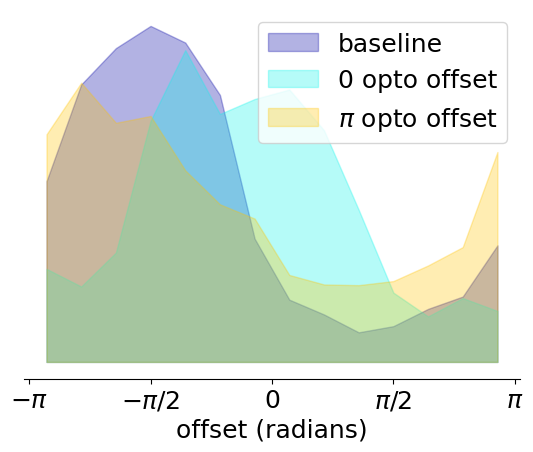

In [12]:
fig,ax = plt.subplots()
cmap = plt.cm.get_cmap('jet')
bin_edges = np.linspace(-np.pi, np.pi, num=15)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2.
labels = ('baseline', '0 opto offset', r'$\pi$ opto offset')
for i, (_offset, _heading_vel) in enumerate(zip(offset,heading_vel)):
    counts, _ = np.histogram(_offset,bins = bin_edges)
    ax.fill_between(bin_centers, counts/counts.sum(), alpha=.3, color=cmap(float(i+.1)/len(offset)), label=labels[i])
ax.legend(loc='upper right')

# ax.plot([0,0],[0,.15], color = cmap(.333))
# ax.plot([bin_centers[-1],bin_centers[-1]],[0,.15], color= cmap(.666))


[np.abs(_heading_vel)>.8]

ax.set_yticks([])
for s in ('top', 'left', 'right'):
    ax.spines[s].set_visible(False)
    
ax.set_xlabel('offset (radians)')

ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels = [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])

basedir = pathlib.PurePath(f"/media/mplitt/SSD_storage/2P_scratch/{data_dict['date']}/{data_dict['fly']}/figs")
os.makedirs(basedir, exist_ok=True)
fig_name = pathlib.Path(basedir.joinpath('offsets.png'))
fig.savefig(fig_name,format='png')
fig_name = pathlib.Path(basedir.joinpath('offsets.pdf'))
fig.savefig(fig_name,format='pdf')


In [16]:
# import cmath
def xcorr_complex(angle0, angle1):
    xcorr = 1/angle0.shape[0]*sp.signal.correlate(np.exp(1j*angle0), np.exp(1j*angle1))
    xcorr_nolag = np.abs(xcorr[heading[0].shape])
    return xcorr_nolag



# sp.stats.pearsonr( complex(np.cos(heading[0]),np.sin(heading[0])), complex(np.cos(heading[0]),np.sin(heading[0])))

In [19]:
sess = 1
nperms = 10000

xcorr_true = xcorr_complex(heading[sess],pva_angle[sess])

xcorr_shuff = []
rng = np.random.default_rng()
for _ in range(nperms):
    head_shuff = np.roll(heading[sess],rng.integers(heading[sess].shape[0]))
    xcorr_shuff.append(xcorr_complex(head_shuff,pva_angle[sess]))
xcorr_shuff = np.array(xcorr_shuff)
print((xcorr_true<xcorr_shuff).sum()/float(nperms))
    

# xcorr_shuff = np.array([xcorr_complex(heading[0][ rng.integers(0, heading[0].shape[0])], pva_angle[0]) for _ in range(1000)])


0.0929


In [14]:
r, p = sp.stats.pearsonr( (np.cos(heading[0]) + np.sin(heading[0])j), np.cos(pva_angle[0]) + np.sin(pva_angle[0])j )
print(r,p)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2557114118.py, line 1)

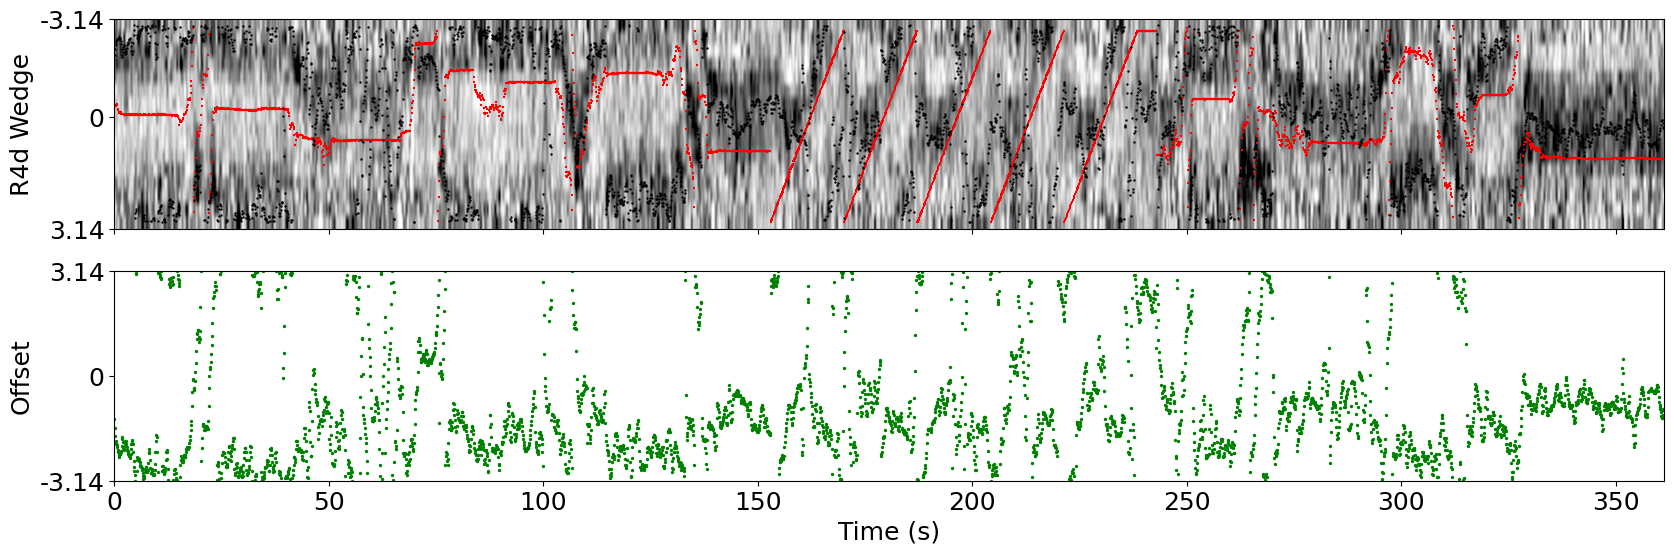

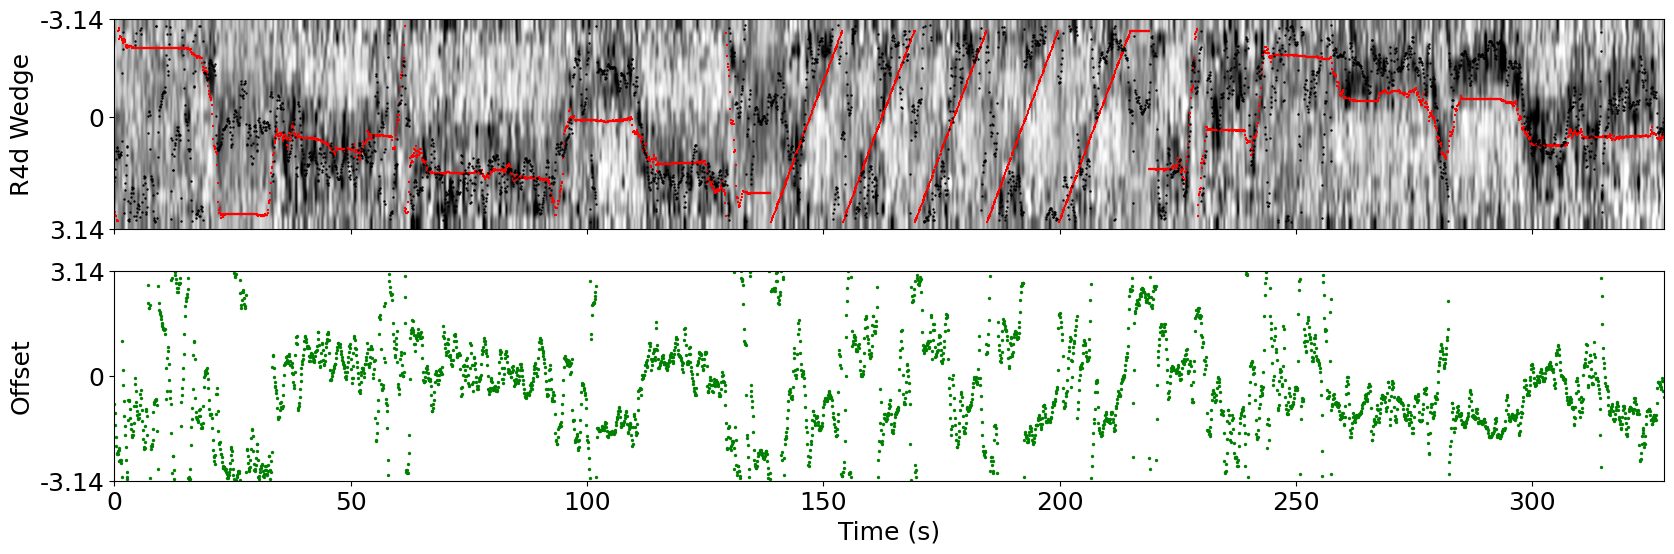

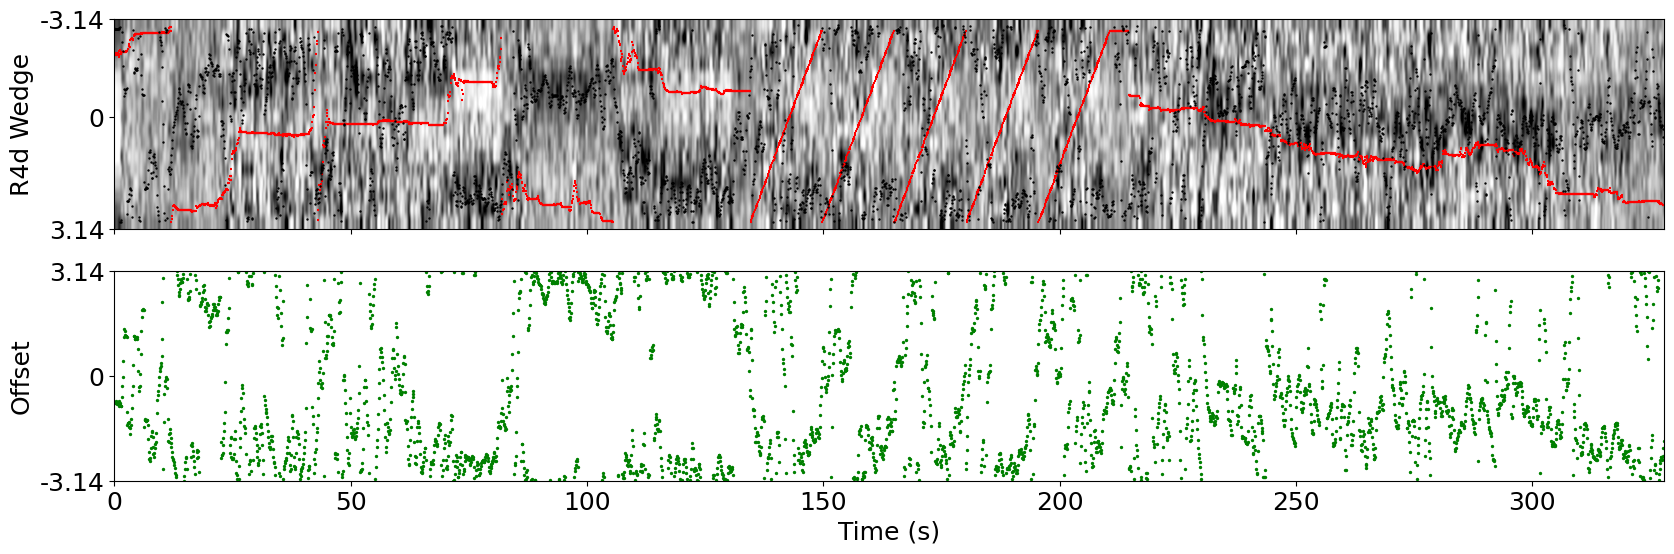

In [14]:


for i, (_dff, _heading, _pva_angle, _offset) in enumerate(zip(dff, heading, pva_angle, offset)):
    fig, ax = plt.subplots(2,1,figsize=[20,6], sharex=True)
    
    ax[0].imshow(_dff,aspect='auto',cmap='Greys',vmin=-2.5,vmax=2.5)
    
    x = np.arange(_dff.shape[1])
    # print(start+1000,stop,heading.shape)
    ax[0].scatter(x,15*(_heading+np.pi)/2/np.pi,color='red',marker='_', s=1)
    
    
    ax[0].scatter(x,15*(_pva_angle+np.pi)/2/np.pi,color='black', s=.5)
    ax[0].set_yticks([-.5, 7, 15.5])
    ax[0].set_yticklabels([-3.14, 0, 3.14])
    ax[0].set_ylabel('R4d Wedge')
    
    cmap = plt.cm.get_cmap('jet')
    ax[1].scatter(x,_offset,s=2, color='green') #color=cmap(float(i+.1)/len(offset)))
    ax[1].set_ylim([-3.14,3.14])
    ax[1].set_yticks([-3.14,0,3.14])
    ax[1].set_yticklabels([-3.14, 0, 3.14])
    ax[1].set_ylabel('Offset')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_xticks(x[0::500], labels=[str(int(i/10)) for i in range(0,x[-1]+1,500)])
    
    fig.savefig(basedir.joinpath(f'dff_{i}.png'),format='png')
    fig.savefig(basedir.joinpath(f'dff_{i}.pdf'),format='pdf')
